In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry
import seaborn as sns
import plotly.express as px
import re
from matplotlib.colors import TwoSlopeNorm
import missingno as msno
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import math

In [2]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pd.set_option('display.max_columns', None)

In [3]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [4]:
# Projected Coordinate System: how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System: how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Import TRREB rental transactions

In [7]:
rent = pd.read_csv("../data/processed/rent.csv")
rent

,district,Listed_AllApartments,Leased_AllApartments,LeasedvsListed_AllApartments,Year,Quarter,YearQuarter,RoomType,TotalLeased,AvgLeaseRate,TotalLeasedPerRoom,AvgLeaseRatePerRoom
0,C01,2038.0,1194.0,0.585868,2012,1,2012Q1,OneBedroom,759.0,1666.0,759.0,1666.000000
1,C01,2038.0,1194.0,0.585868,2012,1,2012Q1,TwoBedroom,370.0,2510.0,740.0,1255.000000
2,C01,2038.0,1194.0,0.585868,2012,1,2012Q1,ThreeBedroom,6.0,3194.0,18.0,1064.666667
3,C01,2038.0,1194.0,0.585868,2012,1,2012Q1,AllApartments,NaN,NaN,1517.0,1458.377060
4,C01,2160.0,1350.0,0.625000,2012,2,2012Q2,OneBedroom,795.0,1739.0,795.0,1739.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
5595,W10,83.0,31.0,0.373494,2021,3,2021Q3,AllApartments,NaN,NaN,48.0,1295.520833
5596,W10,85.0,46.0,0.541176,2021,4,2021Q4,OneBedroom,19.0,1804.0,19.0,1804.000000
5597,W10,85.0,46.0,0.541176,2021,4,2021Q4,TwoBedroom,24.0,2223.0,48.0,1111.500000
5598,W10,85.0,46.0,0.541176,2021,4,2021Q4,ThreeBedroom,3.0,2483.0,9.0,827.666667


In [20]:
neighborhoods = gpd.read_file('../data/processed/neighbourhoods.geojson')

In [14]:
neighborhoods_rent = neighborhoods[['neighbourhood', 'hood_id', 'district', 'geometry']].merge(rent, on='district')

In [16]:
rent_years = neighborhoods_rent.Year.unique()
rent_quarters = neighborhoods_rent.Quarter.unique()

In [24]:
def plot_rental(var, title, roomtype = None):
    fig, axes = plt.subplots(len(rent_quarters), len(rent_years))
    
    for j in range(axes.shape[1]):
        
        # due to inflation, rental rates in recent years must be higher than those in previous years
        # therefore, it would only make sense to fix the range for the colorbar 
        # such that we compare across quarters to observe seasonal effect (if any) in each year, but not across years
        # selected_period = rent.loc[(rent['Year'] == rent_years[j])]
        # vmin, vmax = selected_period[var].min(), selected_period[var].max()
        # norm = TwoSlopeNorm(vmin=vmin, vcenter= np.mean([vmin, vmax]), vmax=vmax)    
        
        for i in range(axes.shape[0]):         
            plot_df = neighborhoods_rent.loc[(neighborhoods_rent['Quarter'] == rent_quarters[i]) & (neighborhoods_rent['Year'] == rent_years[j])]
            if roomtype is not None:
                plot_df = plot_df.loc[(plot_df['RoomType'] == roomtype)]
            plot_df.plot(column = var, 
                         cmap = 'bwr', 
                        #  norm = norm, 
                         ax = axes[i, j])
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].set_yticks([])
            if i == 0:
                axes[i,j].set_title(rent_years[j])
            if j == 0:
                axes[i,j].set_ylabel("Q" + str(rent_quarters[i]), rotation=90, size='large')

    fig.suptitle(title, size='xx-large')

# Plot trend in lease demand

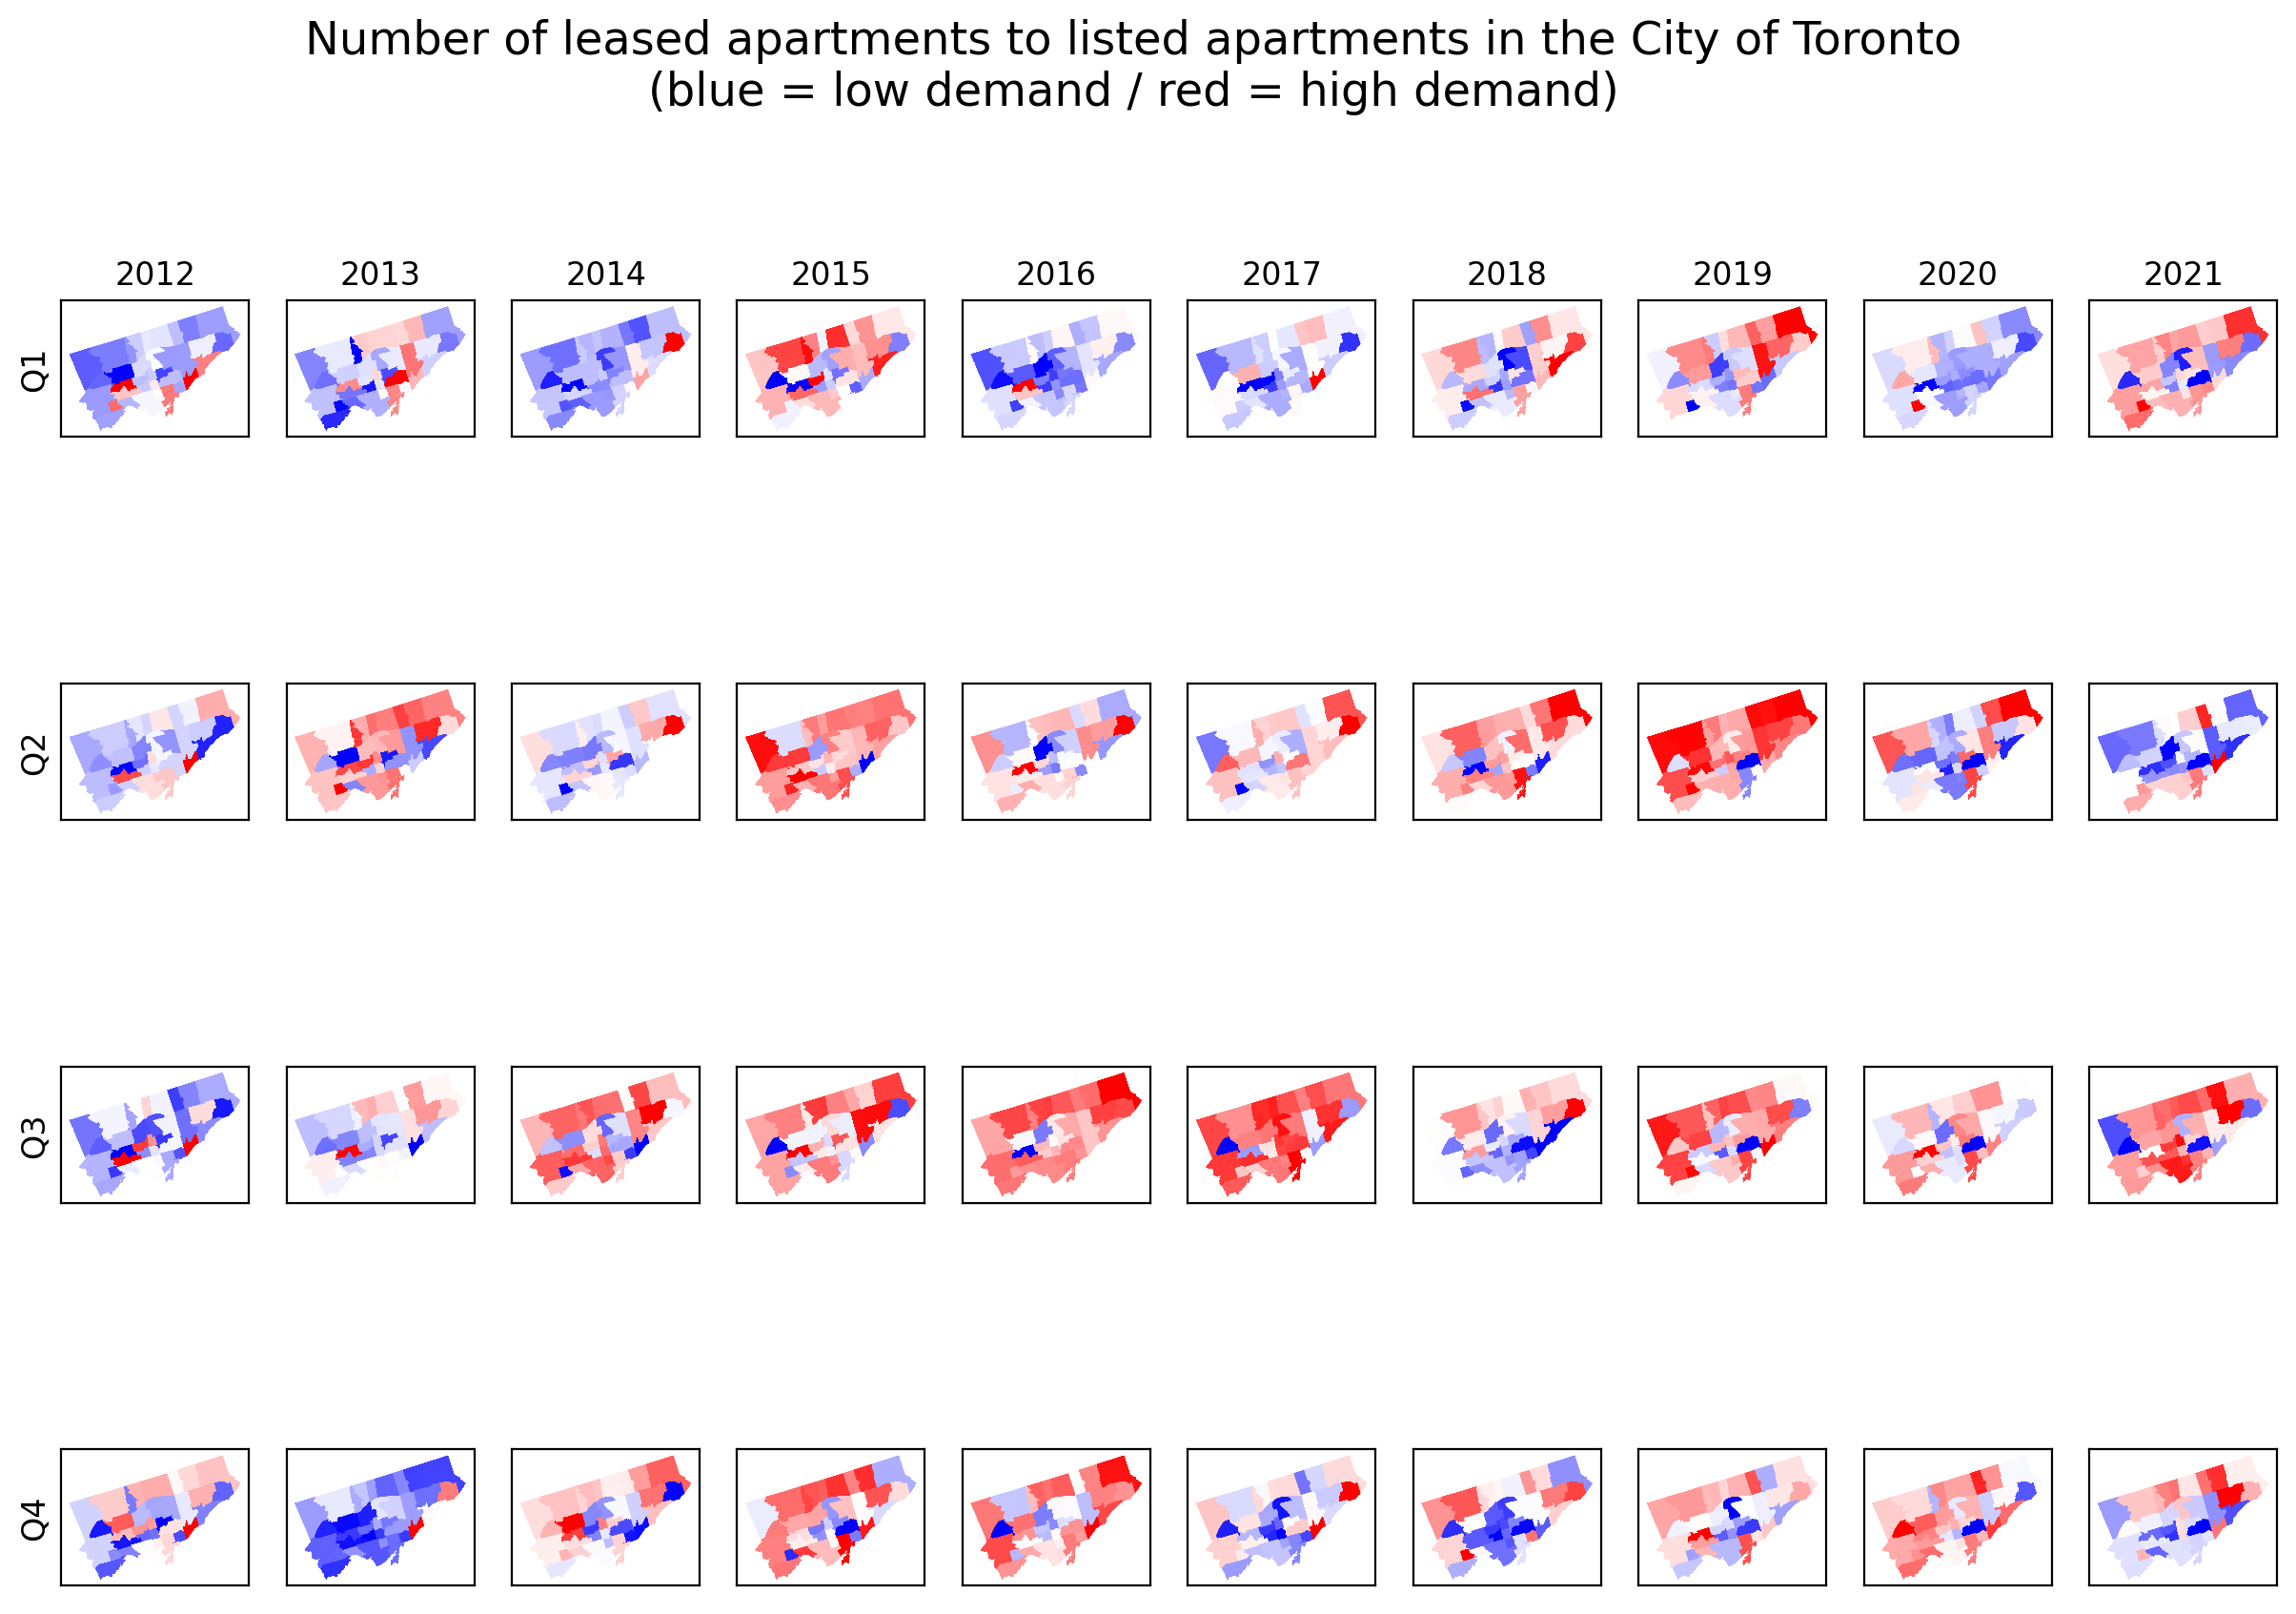

In [26]:
plot_rental('LeasedvsListed_AllApartments', 
            'Number of leased apartments to listed apartments in the City of Toronto\n(blue = low demand / red = high demand)',
            'AllApartments')

# Plot trend in lease rate

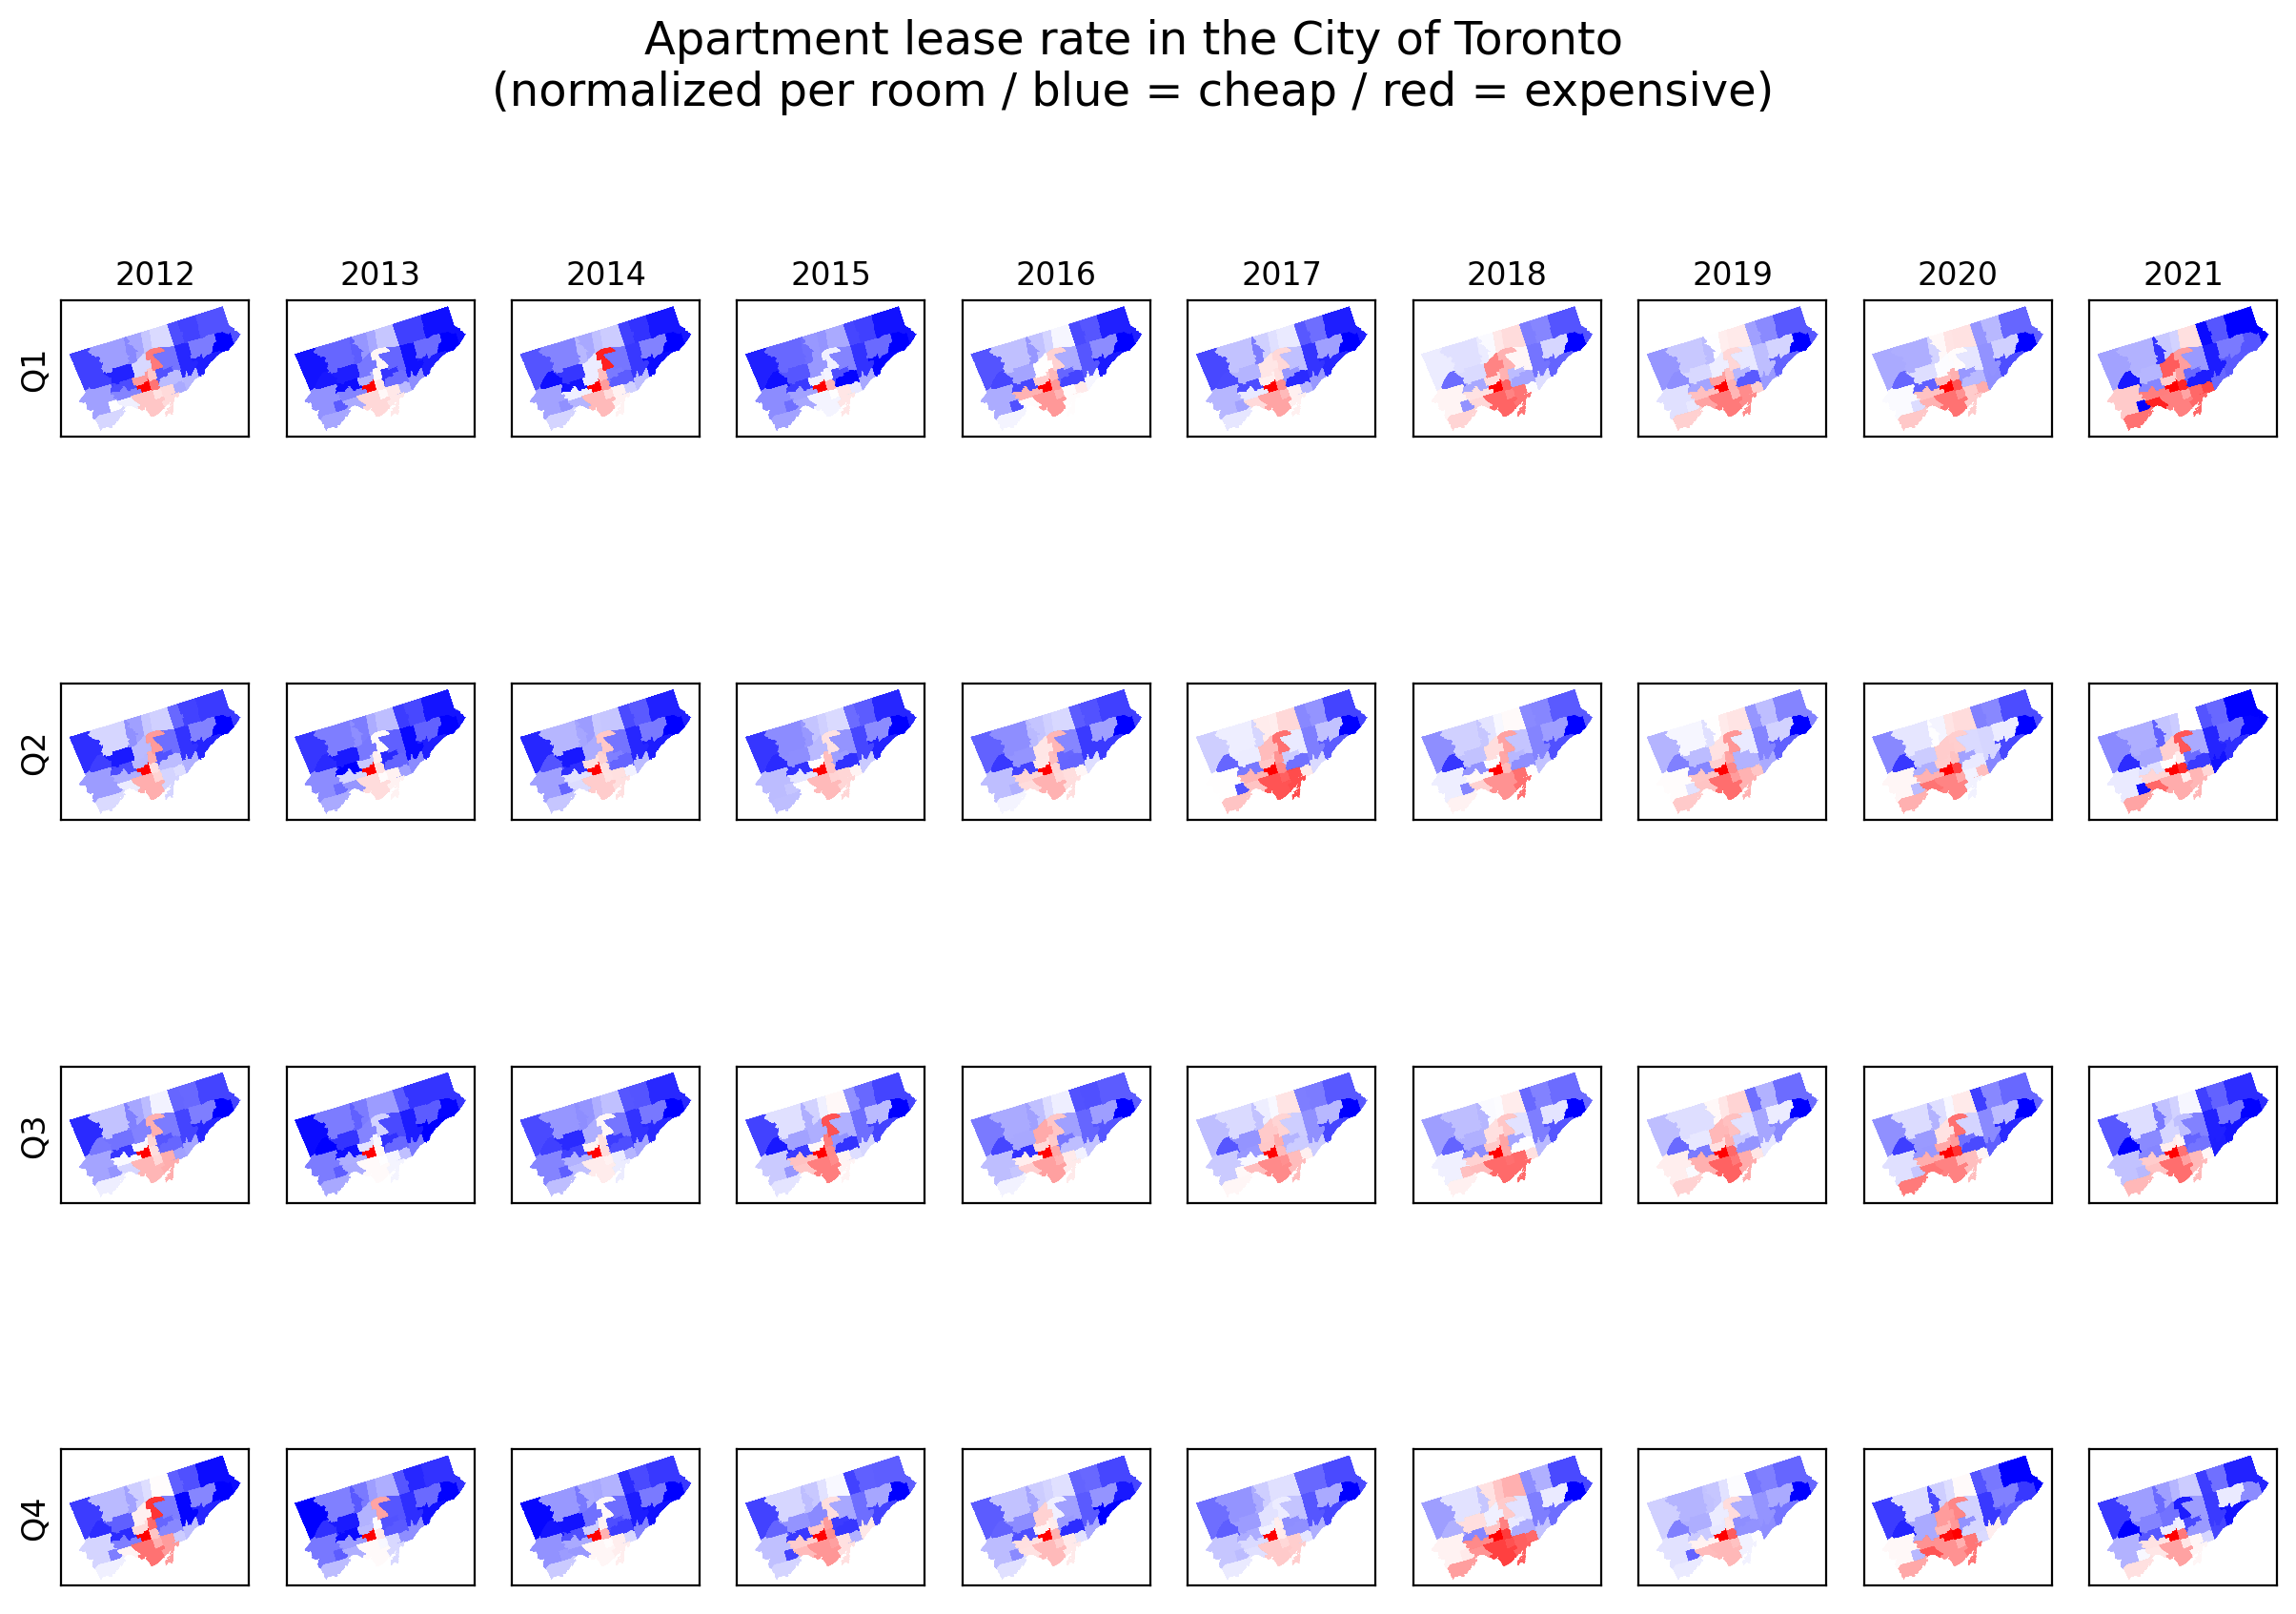

In [25]:
plot_rental('AvgLeaseRatePerRoom', 
            'Apartment lease rate in the City of Toronto\n(normalized per room / blue = cheap / red = expensive)',
            'AllApartments')

# Plot lease demand

Text(0.5, 1.0, 'Recovery in rental demand: ratio of leased to listed apartments has picked up in 2021')

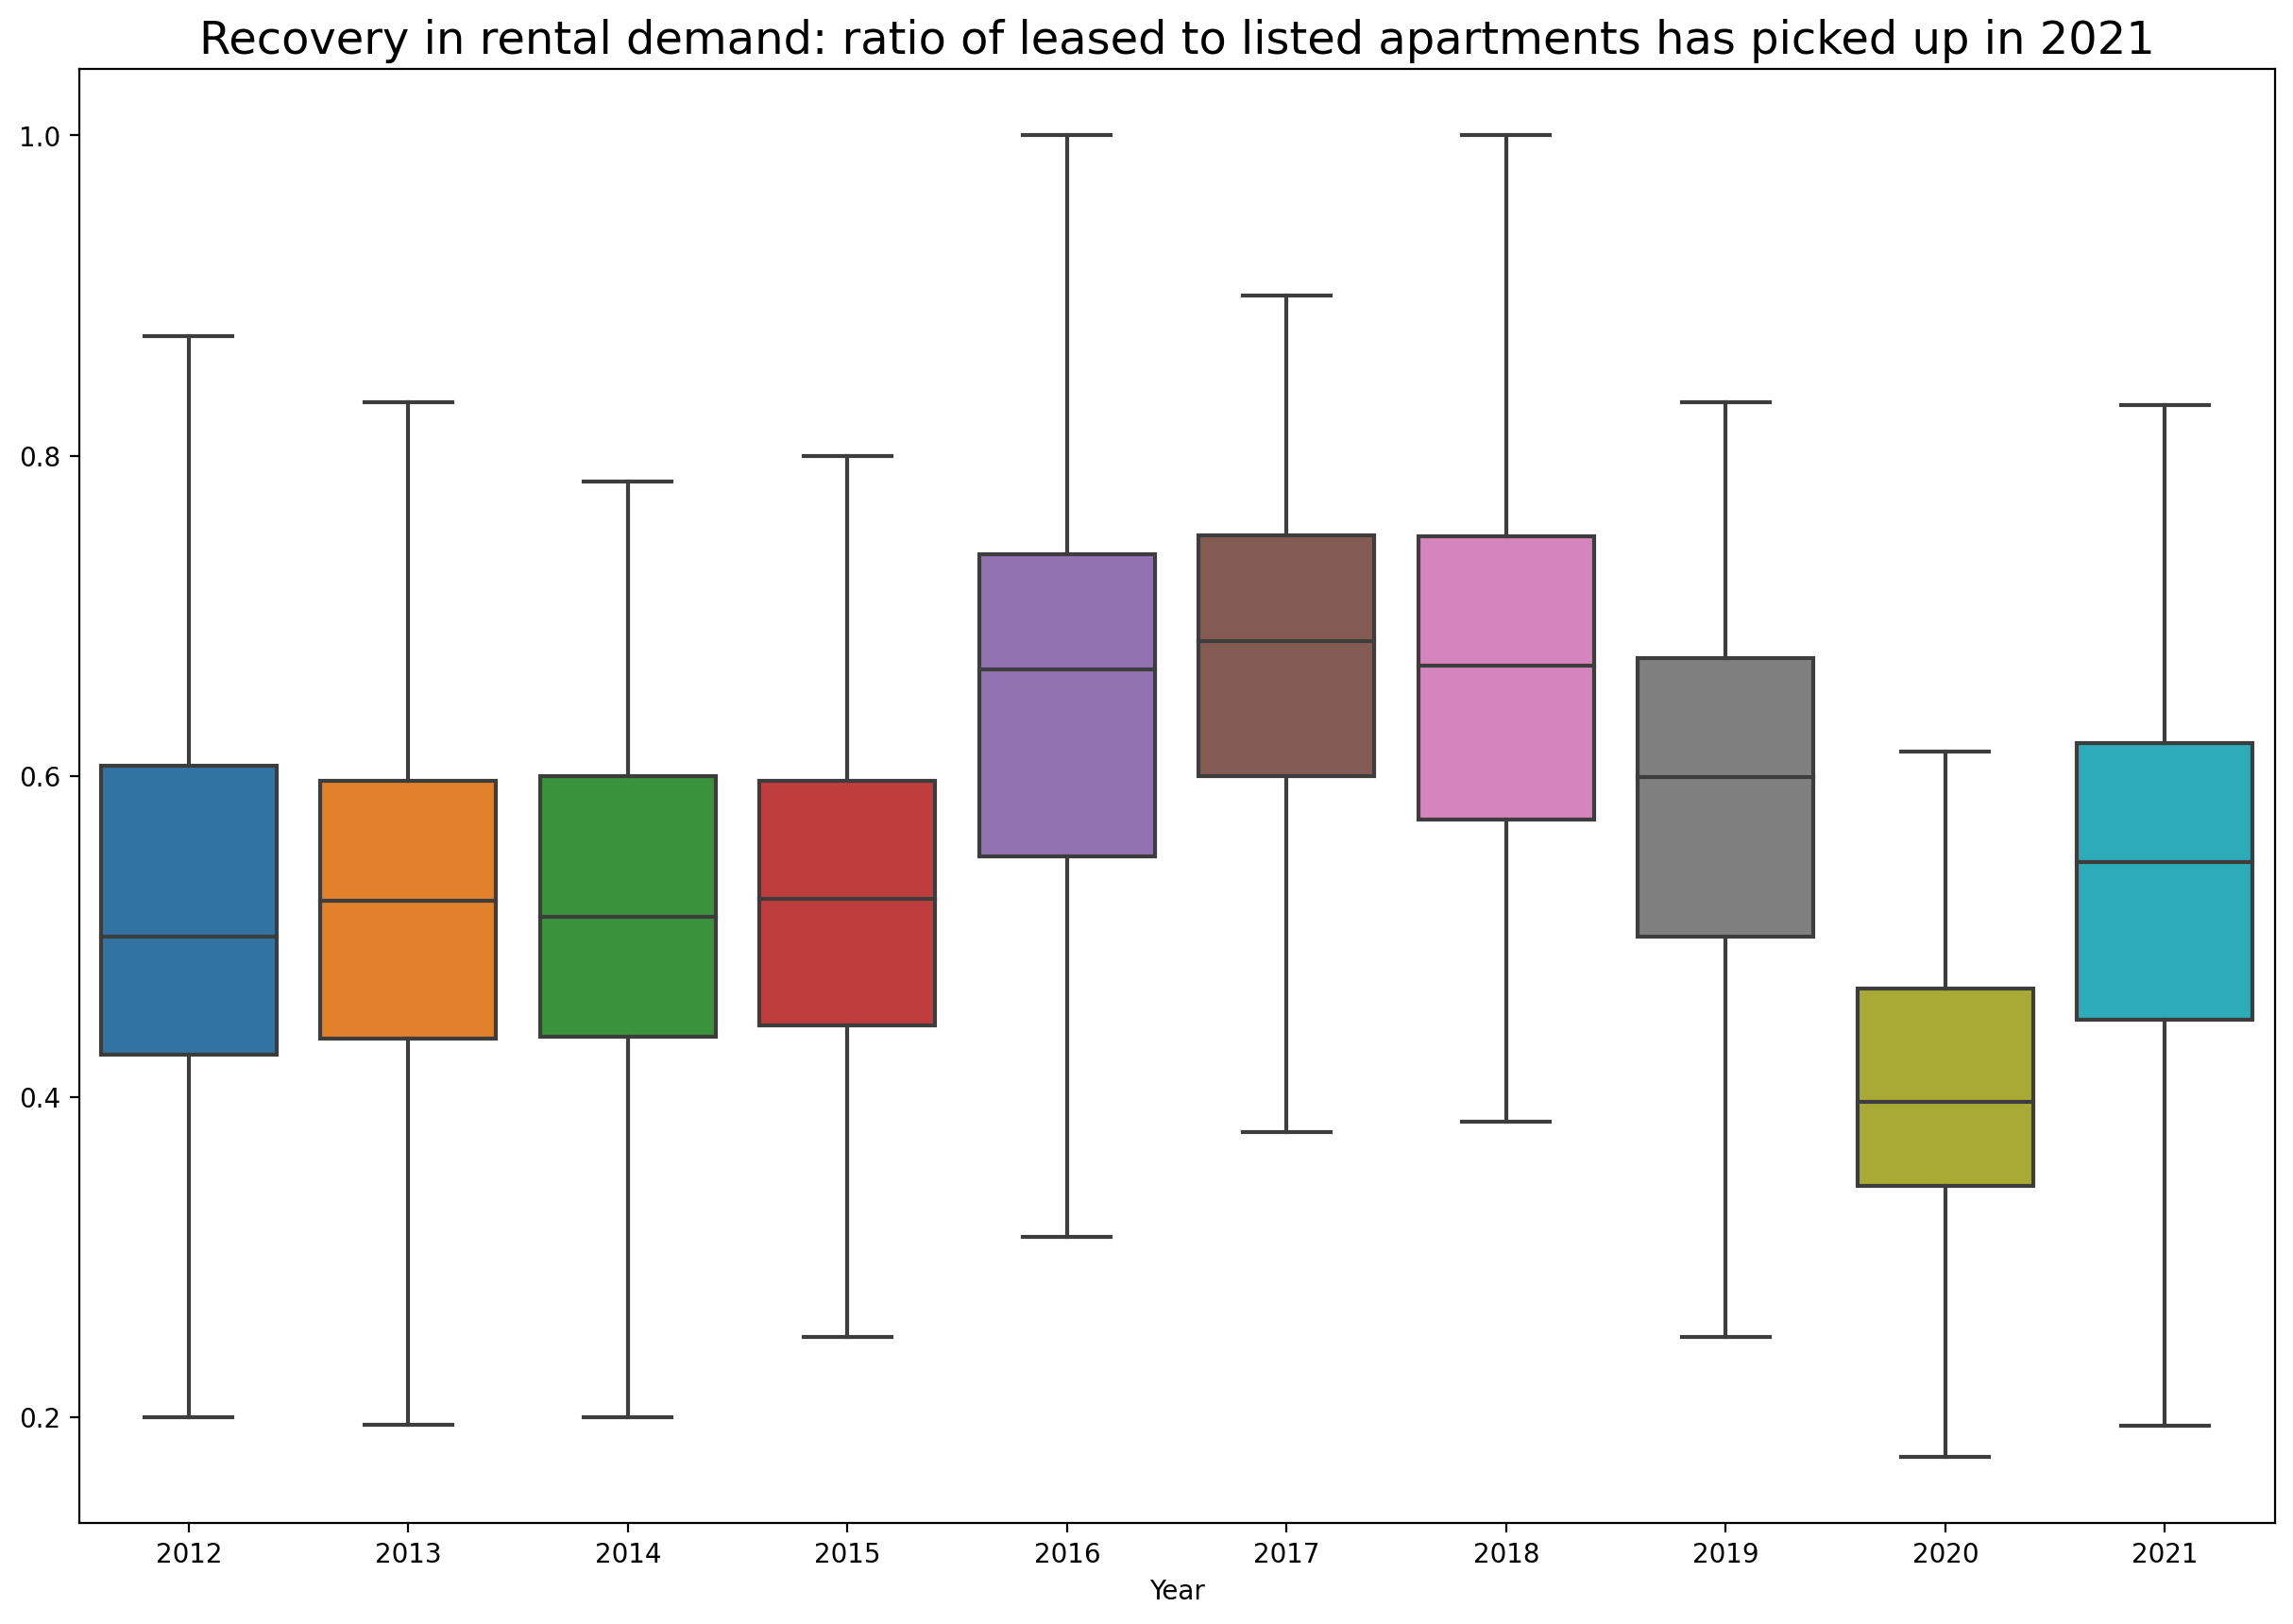

In [27]:
var = 'LeasedvsListed_AllApartments'
title = 'Recovery in rental demand: ratio of leased to listed apartments has picked up in 2021'

ax = sns.boxplot(x='Year', y=var, data=neighborhoods_rent, 
            showfliers = False, # remove outliers
            )
ax.set_ylabel('')
ax.set_title(title, size='xx-large')

# Yearly effect

Text(0.5, 1.1, 'Lease rates for apartments have tapered off since the spike in 2019\n(normalized by number of rooms)')

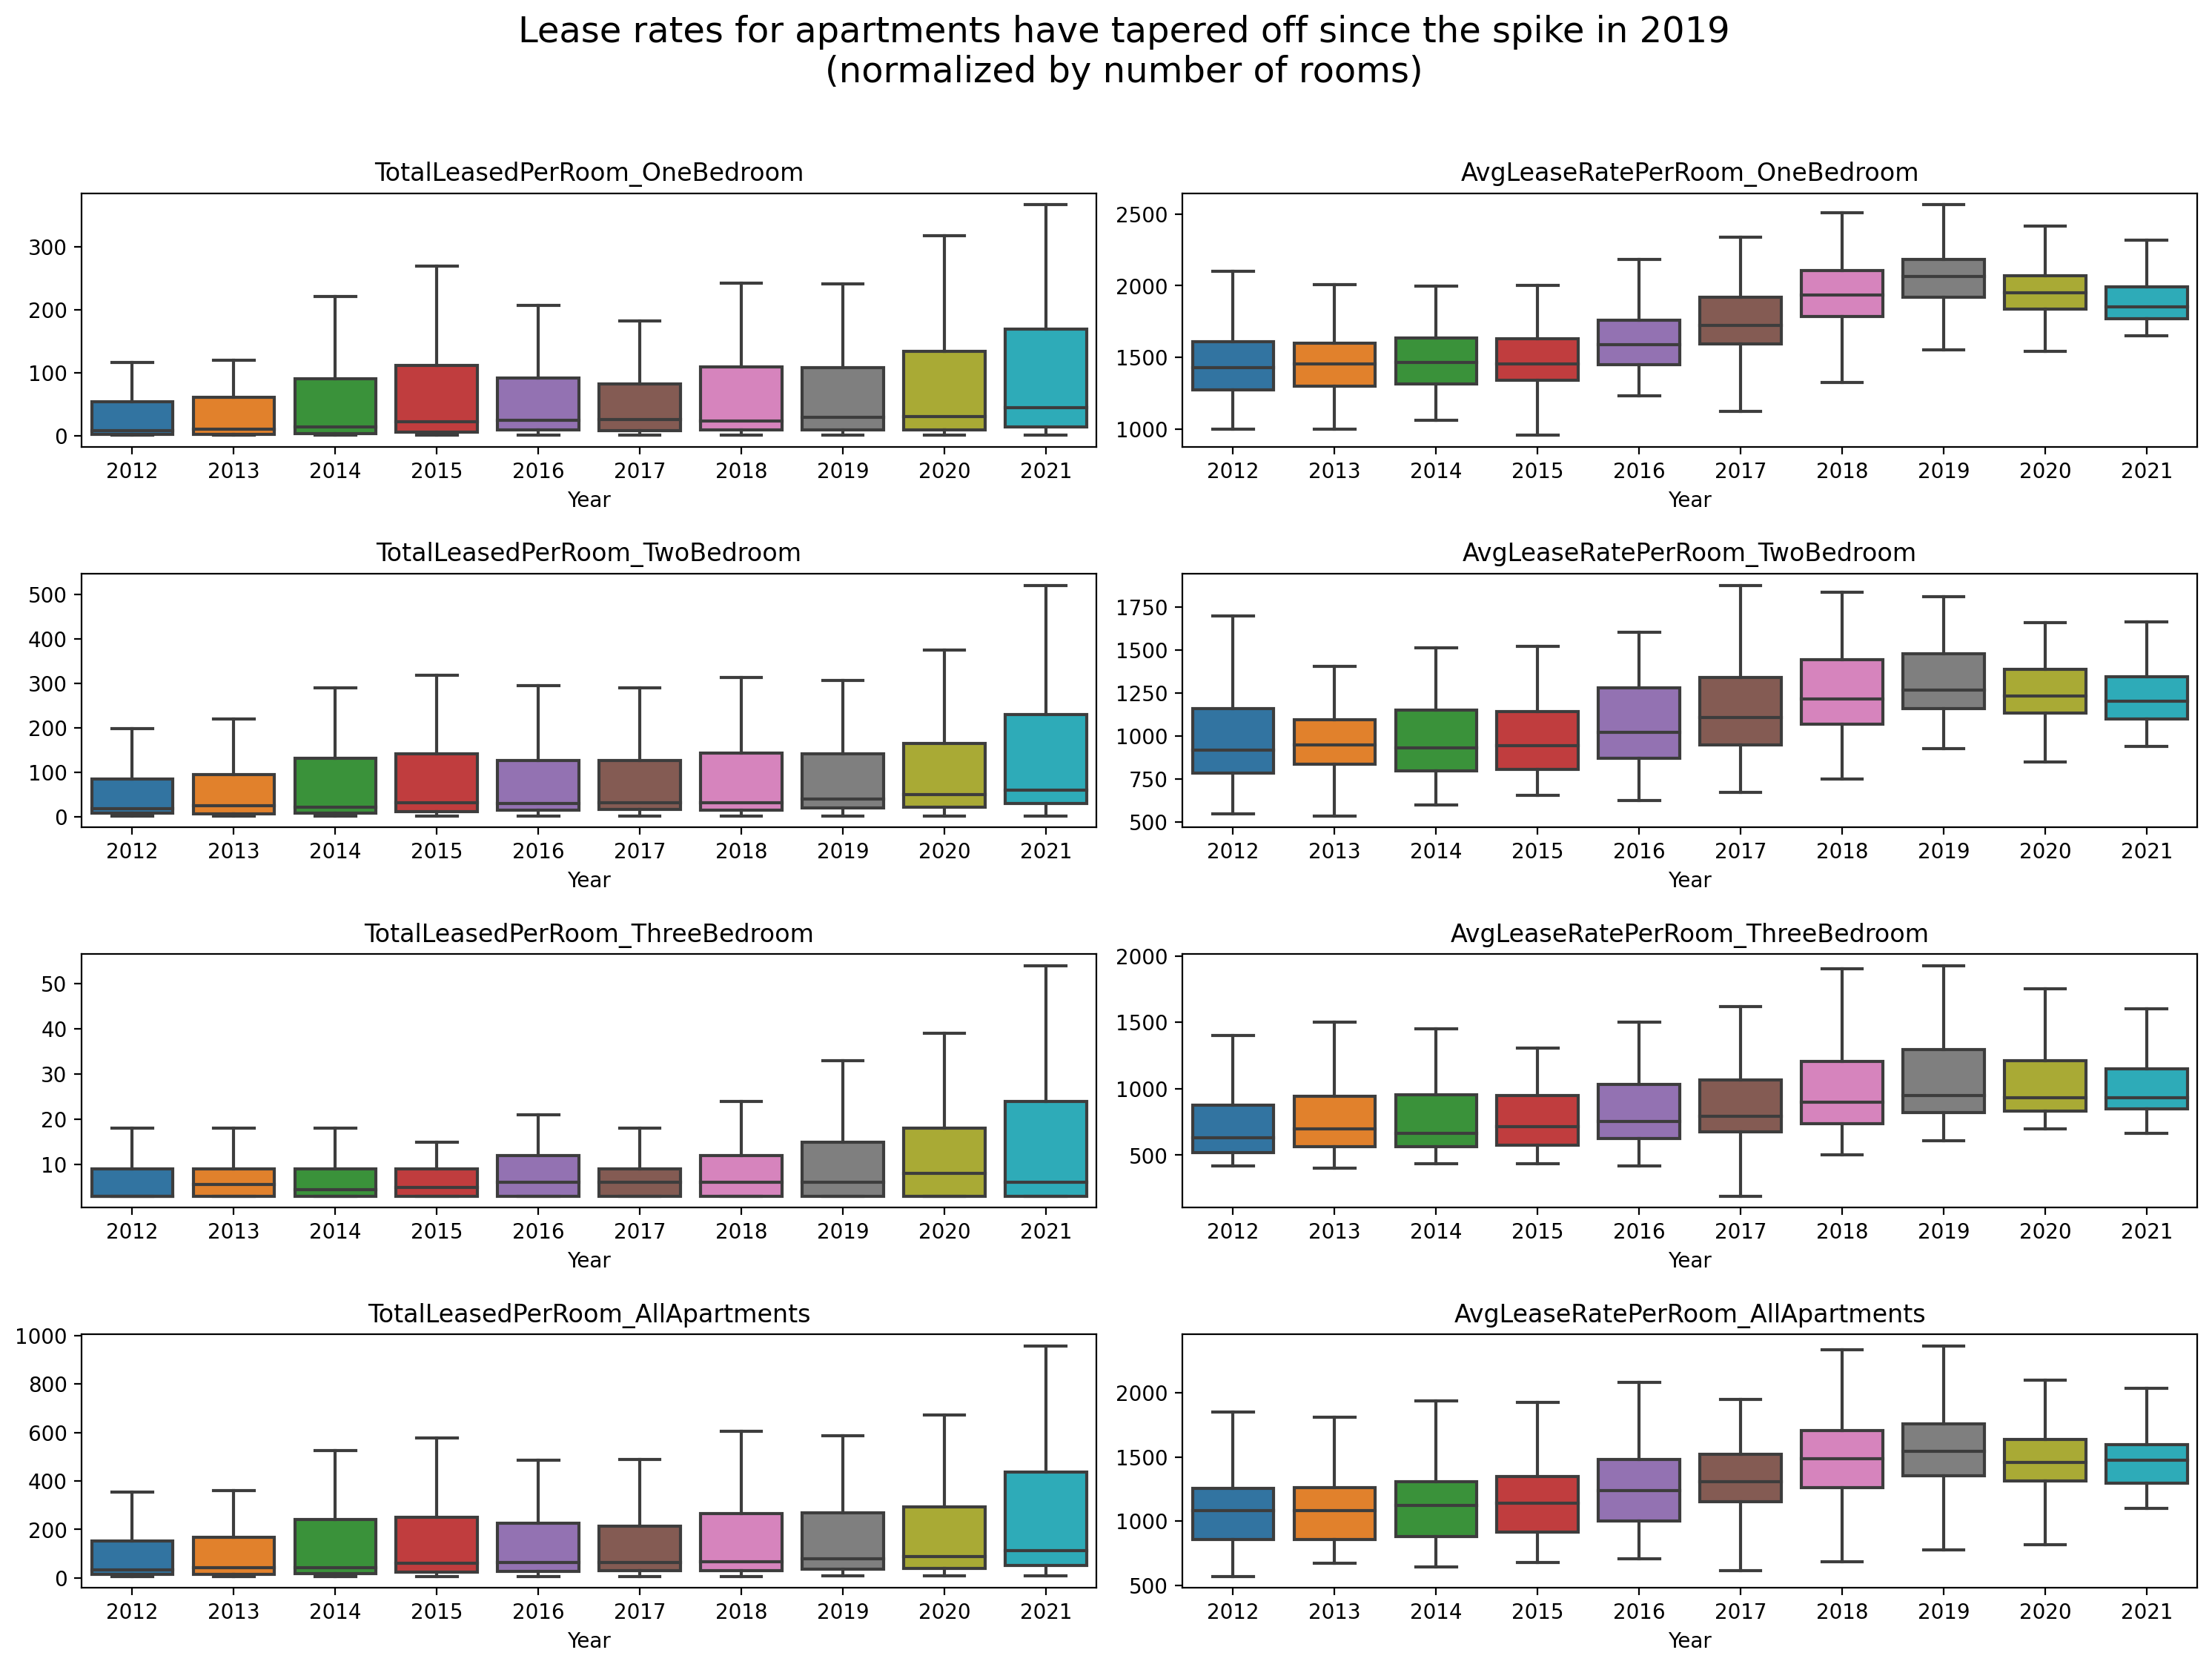

In [34]:
var1 = ['OneBedroom', 'TwoBedroom', 'ThreeBedroom', 'AllApartments']
var2 = ['TotalLeasedPerRoom', 'AvgLeaseRatePerRoom']

fig, axes = plt.subplots(int(len(var1) * len(var2) / 2),2)
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)
for (v1, v2), ax in zip([(v1, v2) for v1 in var1 for v2 in var2], axes.flatten()):
    sns.boxplot(x='Year', y=v2, data=neighborhoods_rent.loc[neighborhoods_rent['RoomType'] == v1], 
                showfliers = False, # remove outliers
                ax=ax)
    ax.set_ylabel('')
    ax.set_title(v2 + '_' + v1)
    
fig.suptitle('Lease rates for apartments have tapered off since the spike in 2019\n(normalized by number of rooms)', 
             size='xx-large', y = 1.1)

# Quarterly effect

Text(0.5, 1.1, 'Quarterly effect: lease rates are stable throughout the year despite strong demand in Q3 due to school season\n(normalized by number of rooms)')

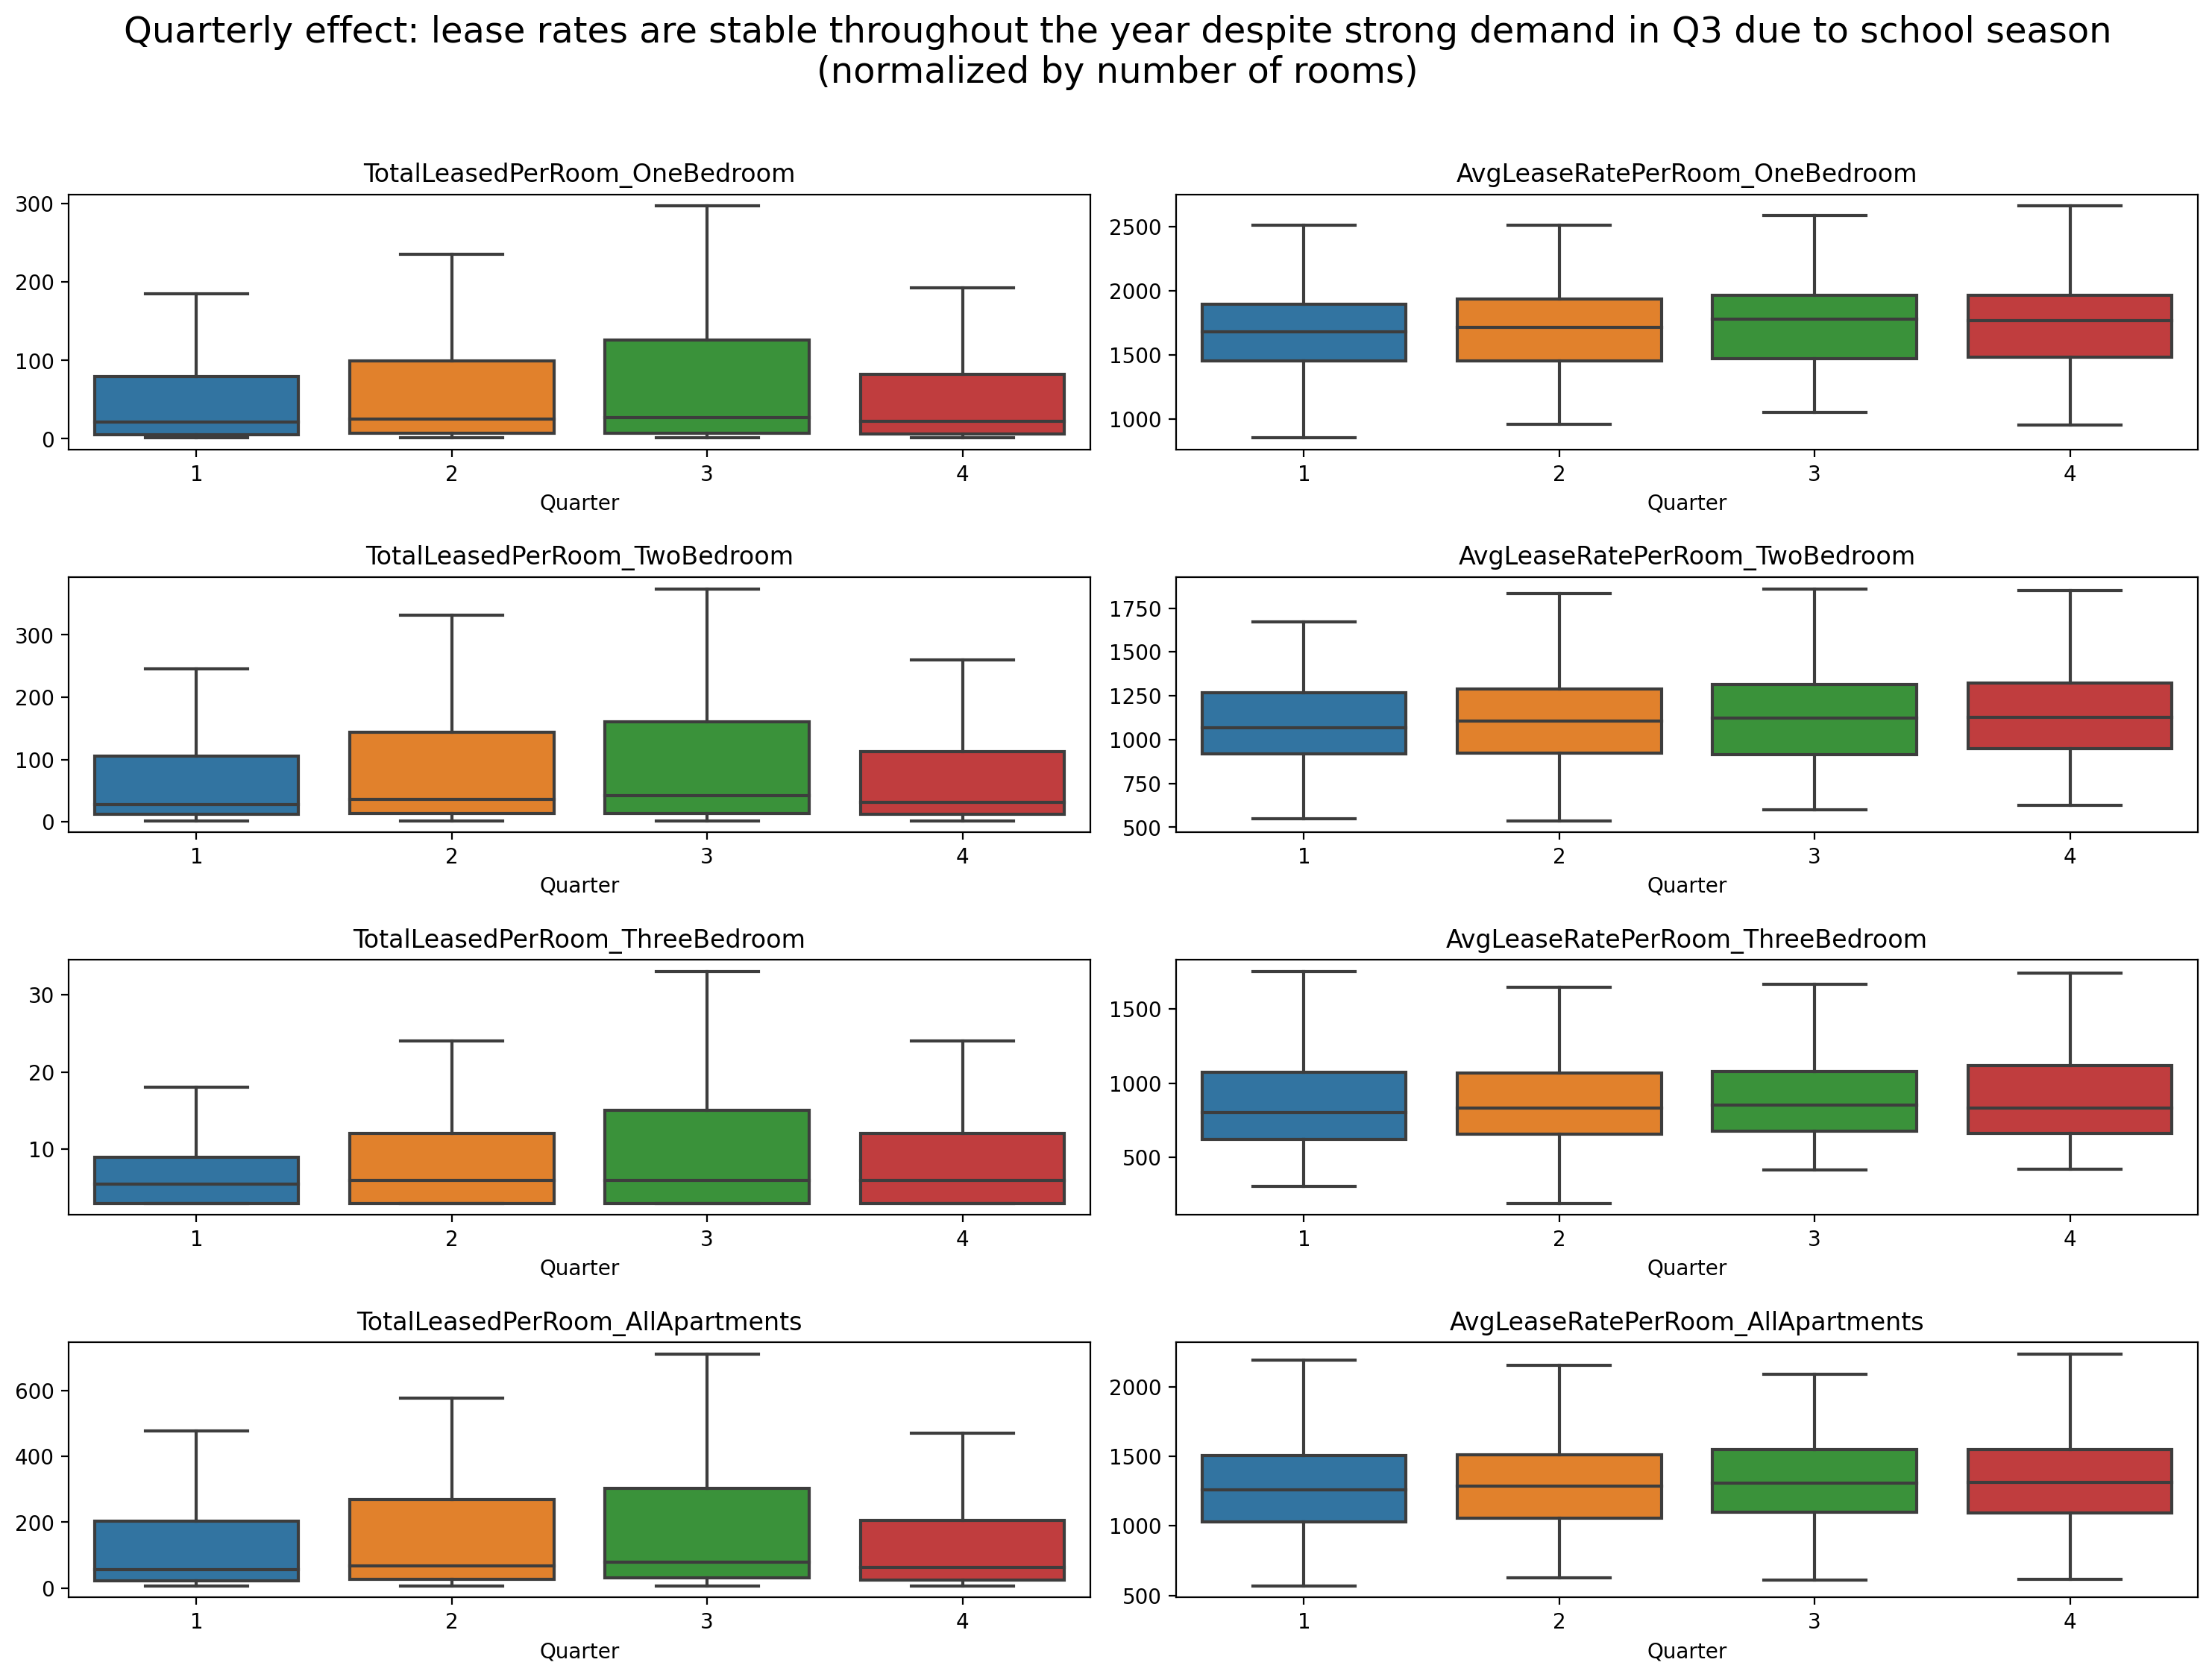

In [35]:
fig, axes = plt.subplots(int(len(var1) * len(var2) / 2),2)
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)
for (v1, v2), ax in zip([(v1, v2) for v1 in var1 for v2 in var2], axes.flatten()):
    sns.boxplot(x='Quarter', y=v2, data=neighborhoods_rent.loc[neighborhoods_rent['RoomType'] == v1], 
                showfliers = False, # remove outliers
                ax=ax)
    ax.set_ylabel('')
    ax.set_title(v2 + '_' + v1)
    
fig.suptitle('Quarterly effect: lease rates are stable throughout the year despite strong demand in Q3 due to school season\n(normalized by number of rooms)', 
             size='xx-large', y = 1.1)

# Plot all together

In [38]:
stations_point = gpd.read_file('../data/processed/stations_point.geojson')
stations_area = gpd.read_file('../data/processed/stations_area.geojson')

Top 5 most expensive MLS districts: 
 district
C02    2276.903986
C09    2037.943798
C01    1924.752591
W06    1840.642258
W01    1701.609756
Name: AvgLeaseRatePerRoom, dtype: float64


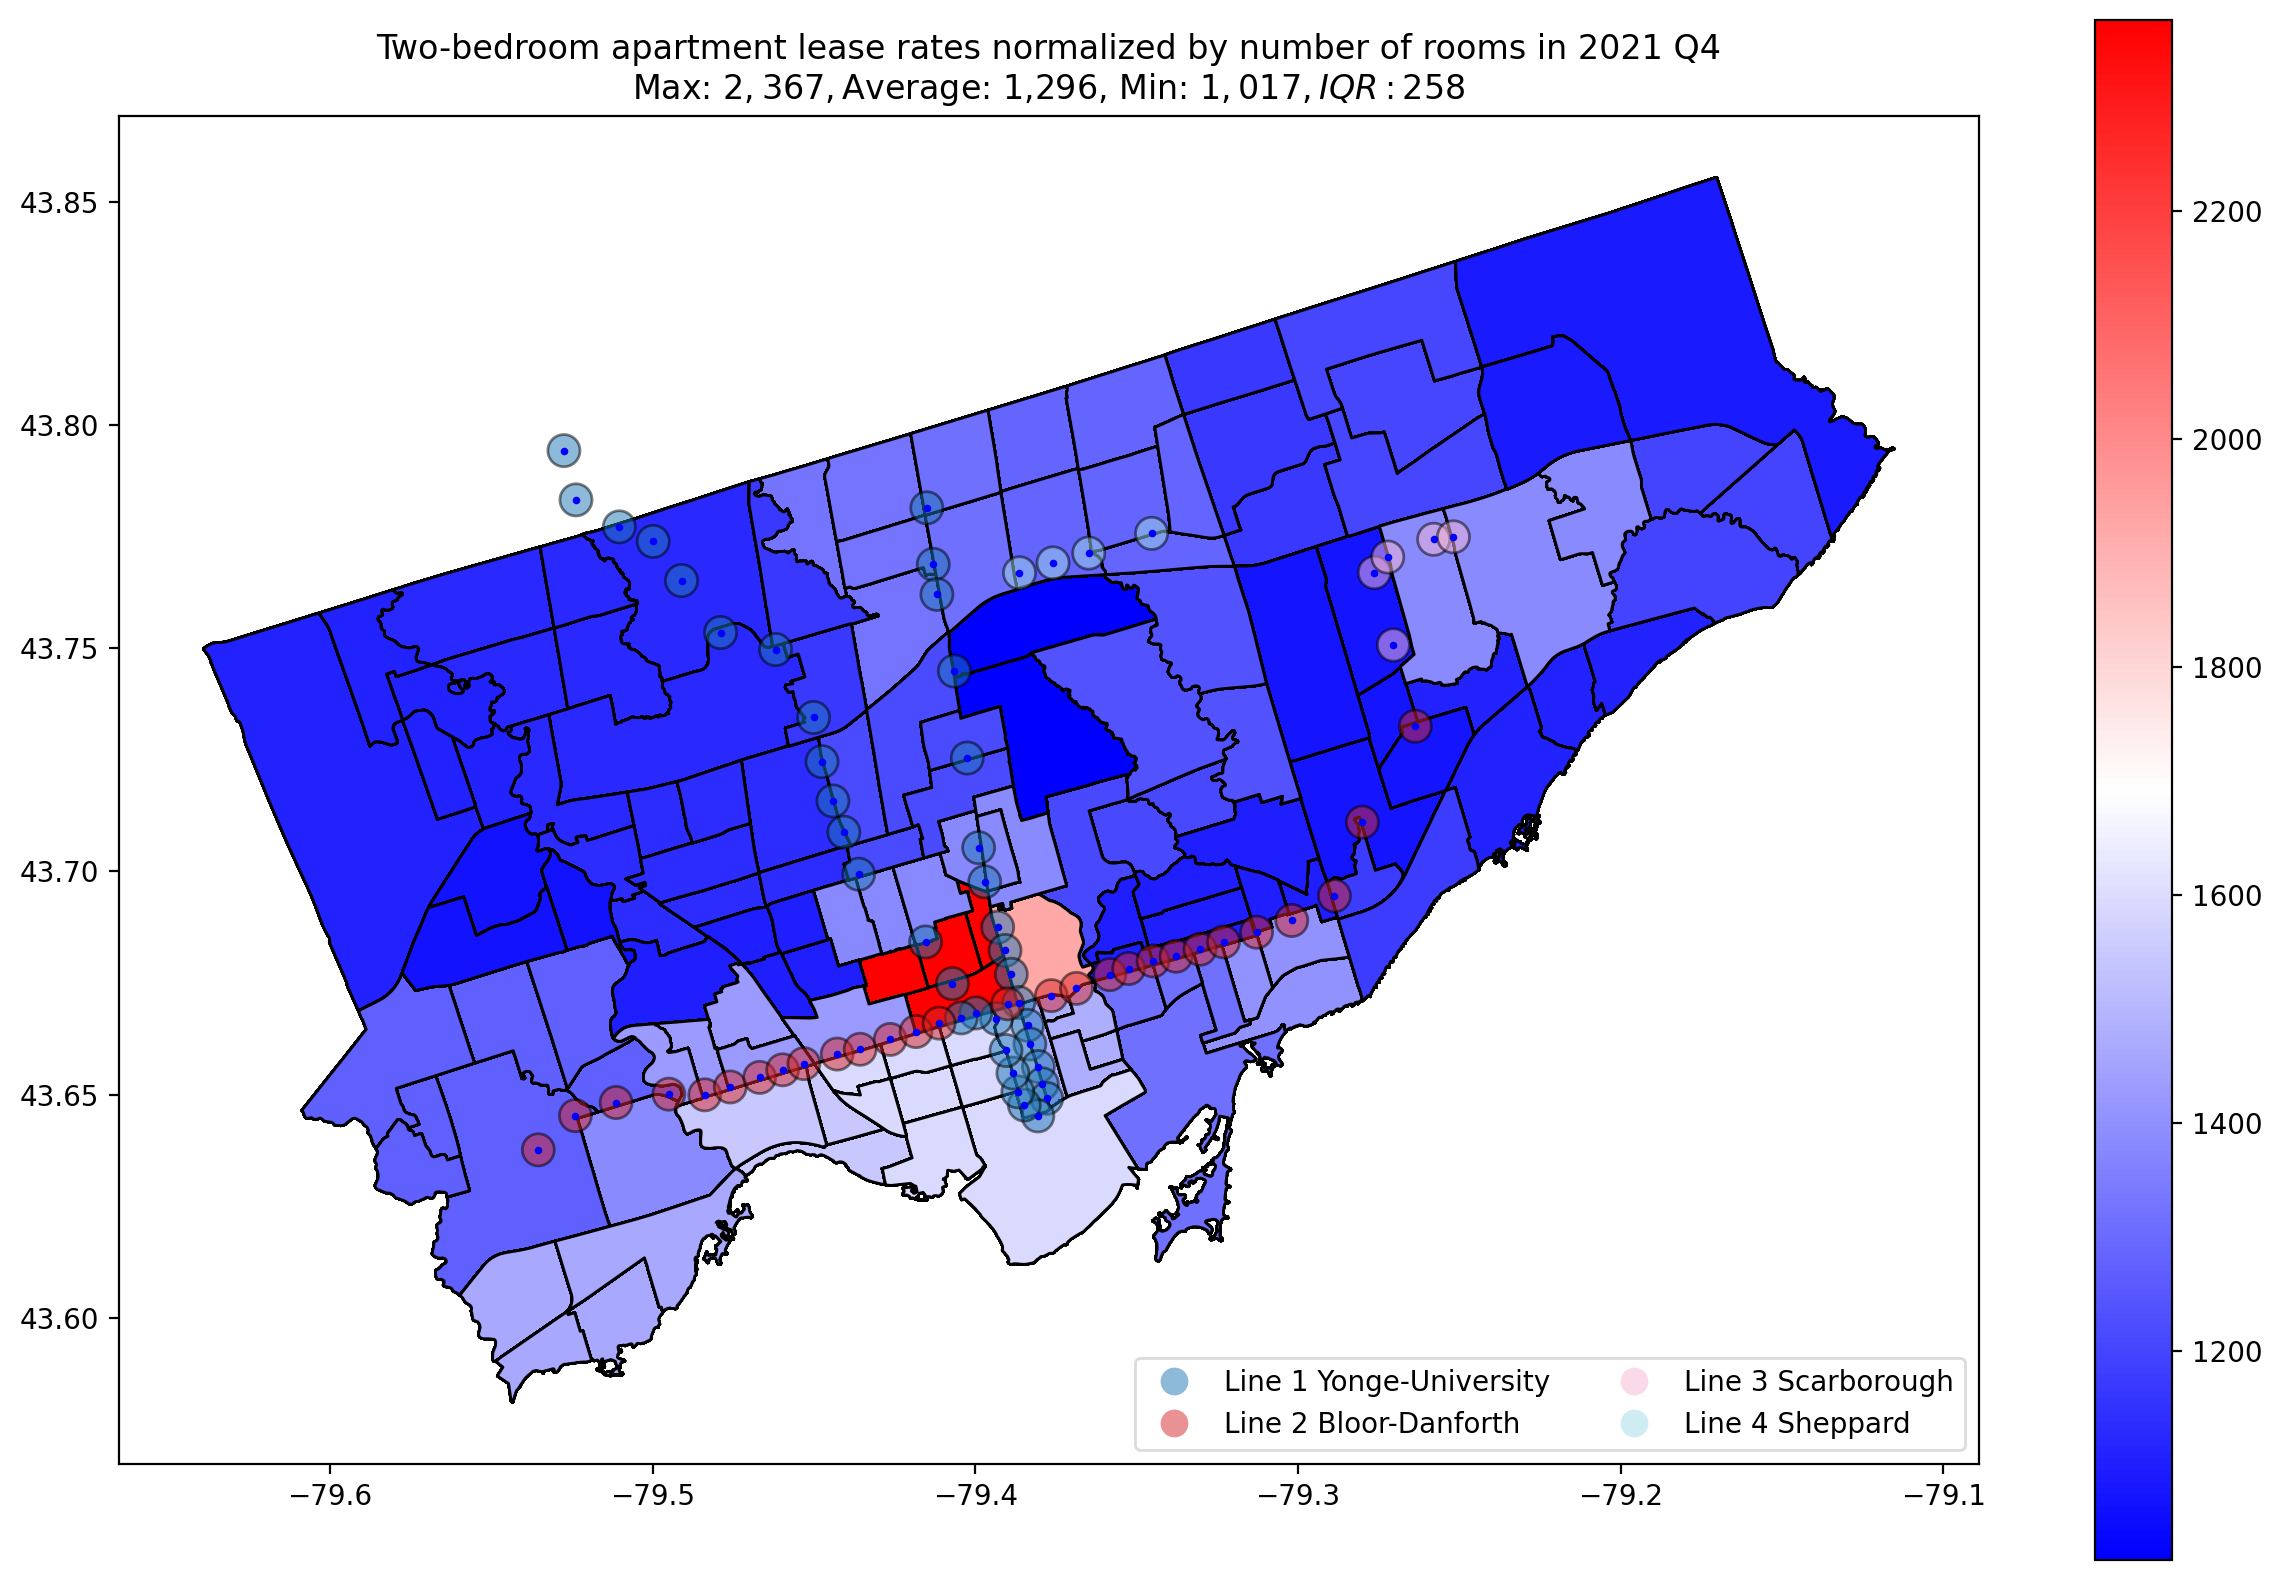

In [39]:
selected_year = 2021
selected_quarter = 4
var = 'AvgLeaseRatePerRoom'
room = 'TwoBedroom'
selected_period = neighborhoods_rent.loc[(neighborhoods_rent['Year'] == selected_year) &
                                         (neighborhoods_rent['Quarter'] == selected_quarter) &
                                         (neighborhoods_rent['RoomType'] == room)]


ax = selected_period.plot(column = var,
                     legend = True,
                     edgecolor = 'black',
                     cmap = "bwr",
                     )

# annotate MLS districts
# for geometry, label in zip(selected_period.geometry, selected_period.district):
#     ax.annotate(label, xy=(geometry.centroid.x, geometry.centroid.y), ha='center')
    
stations_area.plot(column = 'line', 
                edgecolor = 'black', 
                alpha = 0.5,
                cmap = 'tab20',
                legend = True,
                legend_kwds = {'loc': 'lower right', 
                                'ncol': 2,
                                'edgecolor': 'lightgrey'},
                ax = ax)
stations_point.plot(ax=ax, 
                    color = 'blue', 
                    markersize = 3)

    
ax.set_title(f"Two-bedroom apartment lease rates normalized by number of rooms in {selected_year} Q{selected_quarter}\nMax: ${selected_period[var].max():,.0f}, $Average: {selected_period[var].mean():,.0f}, Min: ${selected_period[var].min():,.0f}, IQR: ${selected_period[var].quantile(0.75) - selected_period[var].quantile(0.25):,.0f}")

print("Top 5 most expensive MLS districts: \n",neighborhoods_rent.loc[(neighborhoods_rent['Year'] == selected_year) & (neighborhoods_rent['Quarter'] == selected_quarter)].groupby('district')[var].mean().sort_values(ascending=False).head())